In [46]:
import pandas as pd
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.express as px
import scipy.stats as st
import statsmodels.api as sm

In [2]:
general = pd.read_csv('general_success.csv')
organizer = pd.read_csv('organizer_dollar.csv')
comments = pd.read_csv('comments_dollar.csv')
updates = pd.read_csv('updates_dollar.csv')
#donations = pd.read_csv('donations_dollar.csv')

In [54]:
from statsmodels.formula.api import logit
from statsmodels.formula.api import ols

In [6]:
general['currency'].value_counts()

dollar    3562
euro       160
pound      149
krona       30
franc        3
Name: currency, dtype: int64

In [11]:
#curerncy 별로 success 된 비율이 다를까? - chi square p value 구하기 위해 crosstab 쓰기
#tags 와 success의 crosstabulation - row percentage
df = pd.crosstab(general.currency, general.success, normalize='index').round(4)*100
df

success,False,True
currency,,
dollar,72.38,27.62
euro,87.50,12.50
franc,66.67,33.33
krona,76.67,23.33
pound,78.52,21.48


In [12]:
#p값과 chi2 테스트 값 구하기 위해 모듈 들여오기
from scipy.stats import chi2_contingency
from scipy.stats.distributions import chi2

In [13]:
df1=pd.crosstab(general.currency,general.success).round(4)*100
chi2_con, p, dof, expected = chi2_contingency(df1)

In [14]:
(chi2_con,('%.4f' % p))
#p값이 0.05 이하로, currency는 success와 관계 있음

(2033.6490918303962, '0.0000')

In [96]:
df = general.astype({"funds_raised":"int64"})
df = df[['chid','currency','dum_success','funds_raised_dollar']]
df = df.assign(group_currency = general['currency'])
df

,chid,currency,dum_success,funds_raised_dollar,group_currency
0,1.0,dollar,0,175083,dollar
1,2.0,krona,0,33792,krona
2,3.0,dollar,0,13845,dollar
3,4.0,dollar,0,25,dollar
4,5.0,dollar,0,13950,dollar
...,...,...,...,...,...
3899,3901.0,dollar,1,68691,dollar
3900,3902.0,dollar,1,41330,dollar
3901,3903.0,dollar,1,59205,dollar
3902,3904.0,dollar,0,58767,dollar


In [97]:
def replace(entry):
    
    string = str(entry)
    if string.startswith('d'):
        return 'dollar'
    elif string.startswith('e'): 
        return 'euro'
    else:
        return 'others'


df['group_currency'] = df['group_currency'].apply(replace)
df

,chid,currency,dum_success,funds_raised_dollar,group_currency
0,1.0,dollar,0,175083,dollar
1,2.0,krona,0,33792,others
2,3.0,dollar,0,13845,dollar
3,4.0,dollar,0,25,dollar
4,5.0,dollar,0,13950,dollar
...,...,...,...,...,...
3899,3901.0,dollar,1,68691,dollar
3900,3902.0,dollar,1,41330,dollar
3901,3903.0,dollar,1,59205,dollar
3902,3904.0,dollar,0,58767,dollar


In [98]:
df[['dollar','euro','other']] = pd.get_dummies(df.group_currency)
df = df.astype({"dollar":"float64","euro":"float64","other":"float64"})
df

,chid,currency,dum_success,funds_raised_dollar,group_currency,dollar,euro,other
0,1.0,dollar,0,175083,dollar,1.0,0.0,0.0
1,2.0,krona,0,33792,others,0.0,0.0,1.0
2,3.0,dollar,0,13845,dollar,1.0,0.0,0.0
3,4.0,dollar,0,25,dollar,1.0,0.0,0.0
4,5.0,dollar,0,13950,dollar,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3899,3901.0,dollar,1,68691,dollar,1.0,0.0,0.0
3900,3902.0,dollar,1,41330,dollar,1.0,0.0,0.0
3901,3903.0,dollar,1,59205,dollar,1.0,0.0,0.0
3902,3904.0,dollar,0,58767,dollar,1.0,0.0,0.0


In [99]:
# dollar의 비중이 너무 커서 하지말자!
#ols('funds_raised_dollar ~ dollar + euro + other', data=df).fit().summary()

In [100]:
# 이것도 의미없다. dollar가 너무 크다 하지마.
#a = logit('dum_success ~ other', df).fit()
#a.summary()

In [218]:
# currency별 캠페인 건수와 비율
funds_dollar_counts = df.groupby('currency').agg({'chid':'count','funds_raised_dollar':'sum'})
funds_dollar_counts = funds_dollar_counts.rename(index=str, columns={"chid":"counts","funds_raised_dollar": "amount(dollar)"}).sort_values(by='counts', ascending=False)
funds_dollar_counts = funds_dollar_counts.assign(percentage_by_counts = (round((funds_dollar_counts['counts'] / funds_dollar_counts['counts'].sum()),3)*100))
funds_dollar_counts = funds_dollar_counts.assign(dollar_per_donation = (round(funds_dollar_counts['amount(dollar)'] / funds_dollar_counts['counts'])))
funds_dollar_counts = funds_dollar_counts.reset_index()
funds_dollar_counts

,currency,counts,amount(dollar),percentage_by_counts,dollar_per_donation
0,dollar,3562,275756193,91.2,77416.0
1,euro,160,29726210,4.1,185789.0
2,pound,149,15689655,3.8,105300.0
3,krona,30,384421,0.8,12814.0
4,franc,3,516223,0.1,172074.0


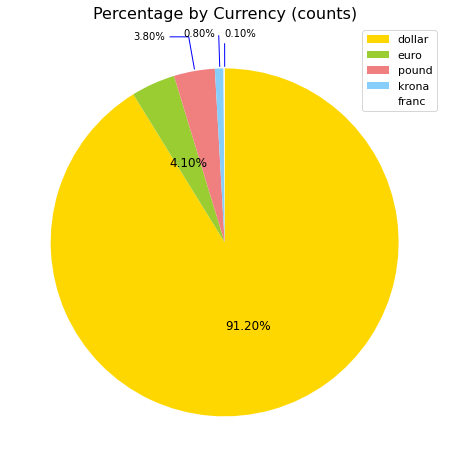

In [222]:
# Currency별 기부자 비율 파이차트 그리기!!

from matplotlib import font_manager, rc
from matplotlib import style
'''
한글 라벨링에 필요
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')
'''
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'white']
labels = funds_dollar_counts['currency']
ratio = funds_dollar_counts['percentage_by_counts']
# explode = (0.0, 0.0, 0.0, 0.0, 0.0)

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임생성

pie = ax.pie(ratio, colors=colors, startangle=90, counterclock=False) 
    #, explode=explode, labels=labels,  autopct='%1.1f%%', shadow=True, textprops={'fontsize':13})

total = np.sum(ratio) ## 빈도수 합

threshold = 4 ## 상한선 비율
sum_pct = 0 ## 퍼센티지
 
bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일
 
## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-', color='b'),bbox=bbox_props,va='center') #퍼센트 선 속성변경
 
for i,l in enumerate(labels):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    
    if i < len(labels) - 1:
        sum_pct += float(f'{ratio[i]/total*100:.2f}')
        text = f'{ratio[i]/total*100:.2f}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    
    ## 비율 상한선보다 작은 것들은 Annotation으로 만든다.
    if ratio[i]/total*100 < threshold:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang-0.2)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일 (A:각도 변경)
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(2*x, 1.2*y),
                    horizontalalignment=horizontalalignment, **config)
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=12)
    
plt.legend(pie[0],labels,loc='upper right', fontsize=11) ## 범례
plt.title('Percentage by Currency (counts)', fontsize=16)
plt.show()


Text(0.5, 1.0, 'Average amount per donations')

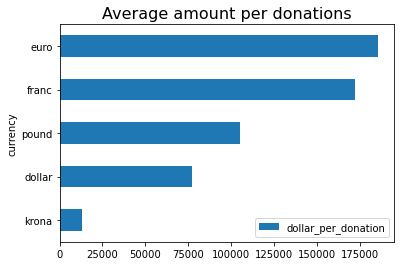

In [223]:
funds_dollar_counts.index=funds_dollar_counts['currency'] #currency를 index로 만들기
bar = funds_dollar_counts[['dollar_per_donation']].sort_values(by=['dollar_per_donation'])
bar.plot(kind='barh')
plt.title('Average amount per donations', fontsize=16)

In [219]:
# dollar, euro, 기타로 그룹지어서도 한번 보자.
cu_group = df.groupby('group_currency').agg({'chid':'count','funds_raised_dollar':'sum'})
cu_group = cu_group.rename(index=str, columns={"chid":"counts","funds_raised_dollar": "amount(dollar)"}).sort_values(by='counts', ascending = False)
cu_group = cu_group.assign(percentage_by_counts = (round((cu_group['counts'] / cu_group['counts'].sum()),3)*100))
cu_group = cu_group.assign(dollar_per_donation = (round(cu_group['amount(dollar)'] / cu_group['counts'])))
cu_group = cu_group.reset_index()
cu_group

,group_currency,counts,amount(dollar),percentage_by_counts,dollar_per_donation
0,dollar,3562,275756193,91.2,77416.0
1,others,182,16590299,4.7,91155.0
2,euro,160,29726210,4.1,185789.0


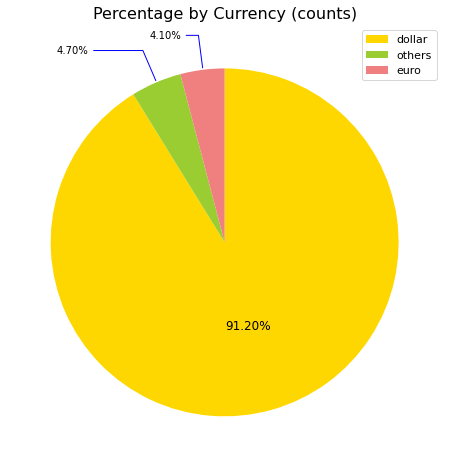

In [214]:
# Currency별 기부자 비율 파이차트 그리기!!

from matplotlib import font_manager, rc
from matplotlib import style
'''
한글 라벨링에 필요
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')
'''
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'white']
labels = cu_group['group_currency']
ratio = cu_group['percentage_by_counts']
# explode = (0.0, 0.0, 0.0, 0.0, 0.0)

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임생성

pie = ax.pie(ratio, colors=colors, startangle=90, counterclock=False) 
    #, explode=explode, labels=labels,  autopct='%1.1f%%', shadow=True, textprops={'fontsize':13})

total = np.sum(ratio) ## 빈도수 합

threshold = 44.5 ## 상한선 비율
sum_pct = 0 ## 퍼센티지
 
bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일
 
## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-', color='b'),bbox=bbox_props,va='center') #퍼센트 선 속성변경
 
for i,l in enumerate(labels):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    
    if i < len(labels) - 1:
        sum_pct += float(f'{ratio[i]/total*100:.2f}')
        text = f'{ratio[i]/total*100:.2f}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    
    ## 비율 상한선보다 작은 것들은 Annotation으로 만든다.
    if ratio[i]/total*100 < threshold:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang-0.2)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일 (A:각도 변경)
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(2*x, 1.2*y),
                    horizontalalignment=horizontalalignment, **config)
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=12)
    
plt.legend(pie[0],labels,loc='upper right', fontsize=11) ## 범례
plt.title('Percentage by Currency (counts)', fontsize=16)
plt.show()


Text(0.5, 1.0, 'Average amount per donations')

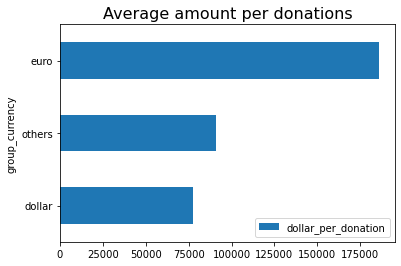

In [217]:
cu_group.index=cu_group['group_currency'] #currency를 index로 만들기
bar1 = cu_group[['dollar_per_donation']].sort_values(by=['dollar_per_donation'])
bar1.plot(kind='barh')
plt.title('Average amount per donations', fontsize=16)